# Using ALEBREW for the generation of training data sets and learning interatomic potentials

This notebook demonstrates how uncertainty-biased molecular dynamics and active learning, as implemented in `ALEBREW`, can efficiently train an interatomic potential for alanine dipeptide from scratch.
We begin by downloading and storing the data from [Zenodo](https://doi.org/10.5281/zenodo.10776838), including `ala2_init.extxyz`, `input.pdb`, `parm7.prmtop`, and `ala2_test.extxyz`. We store them in the `examples/datasets` subfolder. 
Then, we load all necessary modules.

In [1]:
import os
import sys

# set python paths
sys.path.append('/home/vzaverkin/alebrew')

from typing import Tuple, Union, Dict, Any, List

from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch

import ase
from ase.io import read

from alebrew.data.data import AtomicStructures
from alebrew.datagen.references import SingleCalculatorReference
from alebrew.interfaces.ase import TorchMDCalculator
from alebrew.task_execution import CustomPaths, Task, Learner

from alebrew.evaluation.quadtree import WeightedSpacePartitioner
from alebrew.utils.misc import load_object

Define custom paths for `datasets`, `results`, and `plots`.

In [2]:
custom_paths = CustomPaths(folder='.')

Now, we define a learning task for alanine dipeptide, with parameters such as a temperature of 300 K and an integration time step of 0.5 fs. Following the convention outlined in `alebrew/task_execution.py`, we call this task `ala2-300K-ffs`. It is worth noting that we could directly utilize the pre-defined task using `task = Task.create('ala2-300K-ffs', custom_paths=custom_paths, n_threads=1, n_cores=1, force_threshold=20.0)`, as it was defined for our experiments in the [paper](https://arxiv.org/abs/2312.01416). Nevertheless, for completeness, we demonstrate how to design a new task. For more details on the task's parameters, please consult docstrings in `alebrew/task_execution.py`.

In [3]:
init_structures = AtomicStructures.from_extxyz(custom_paths.data_path / 'ala2_init.extxyz')

calc = TorchMDCalculator(input_file=os.path.join(str(custom_paths.data_path), 'input.pdb'),
                         parm_file=os.path.join(str(custom_paths.data_path), 'parm7.prmtop'),
                         r_cutoff=9.0)

reference = SingleCalculatorReference(calc=calc, n_threads=1, force_threshold=20.0)
                                        
test_structures = AtomicStructures.from_extxyz(custom_paths.data_path / 'ala2_test.extxyz')

task = Task(task_name='ala2-300K-ffs', structures=init_structures, use_precomp_labels=False,
            init_structures=init_structures, reference=reference, r_cutoff=5.0,
            atomic_types=['H', 'C', 'N', 'O'], timestep=0.5, temperatures=[300.0],
            externalstresses=[0.0], mask=None, test_structures=test_structures)

After defining the learning task, we can specify the learner and select employed methods, e.g., for biasing and terminating atomistic simulations. Note that different strategies for training, sampling, etc., are provided in `alebrew/strategies.py`; thus, the learning process can be customized even further. However, in this simple example, we employ the `Learner` class used to run experiments in the original [paper](https://arxiv.org/abs/2312.01416). We begin with an unbiased experiment and evaluate it on the specified task. Note that we use `posterior`-based uncertainty. Please use `config.yaml` from [Zenodo](https://doi.org/10.5281/zenodo.10776838) to reproduce the results from the [paper](https://arxiv.org/abs/2312.01416).

Note that we use `multiprocessing` to speed up the exploration process, i.e., atomistic simulations. To make sure `multiprocessing` works properly, one has to include the `if__name__ = '__main__'` clause. The above reasons and the time required to run a single experiment restricts the use of Jupyter notebooks. Therefore, we provide two Python scripts to run unbiased and biased experiments (`run_unbiased_experiments.py` and `run_biased_experiments.py`). Please, make sure to run this scripts on your machine before continuing with this tutorial, i.e., for the unbiased experiment execute, for example, `python run_unbiased_experiment.py > out 2> err &`.

In [4]:
# unbiased_learner = Learner(method_name='random_8_0.02-nvt_1.5_20000_200_8-posterior-max_det_8_512-0', 
#                            pre_sampling_method='random', max_pre_sampling_step=8, amplitude_shift=0.02,
#                            sampling_method='nvt', friction=0.02, atomic_unc_threshold=1.5, eval_sampling_step=200, 
#                            max_sampling_step=20000, n_samplers=8, n_threads=8, write_traj_details=True, 
#                            write_traj_properties=['energy', 'forces'], unc_method='posterior', posterior_sigma=0.01, 
#                            compute_atomic_unc=True, atomic_unc_residual='forces_rmse', conformal_alpha=0.05, 
#                            use_grad_features=True, n_random_projections=512, sel_method='max_det', 
#                            max_sel_batch_size=8, calibr_batch_size=32, eval_batch_size=32, max_data_size=512, 
#                            valid_fraction=0.1, data_seed=0, sampling_seed=0, model_seeds=[0], custom_paths=custom_paths)

# unbiased_learner.run_on_task(task)

Next, we run the biased experiment (`python run_biased_experiment.py > out 2> err &`).

In [5]:
# relative_atom_weights = np.ones(10)
# relative_atom_weights[1] = 0.0  # set the relative hydrogen's biasing strength to zero

# biased_learner = Learner(method_name=f'random_8_0.02-nvt_1.5_20000_200_8-linear_unc_0.25_0.0-posterior-max_det_8_512-0',
#                          pre_sampling_method='random', max_pre_sampling_step=8, amplitude_shift=0.02,
#                          sampling_method='nvt', friction=0.02, atomic_unc_threshold=1.5, eval_sampling_step=200, 
#                          max_sampling_step=20000, n_samplers=8, n_threads=8, write_traj_details=True,
#                          write_traj_properties=['energy', 'forces'], unc_method='posterior', posterior_sigma=0.01, 
#                          compute_atomic_unc=True, atomic_unc_residual='forces_rmse', conformal_alpha=0.05, 
#                          use_grad_features=True, n_random_projections=512, bias_method='linear_unc', forces_biasing_strength=0.25, 
#                          forces_burn_in_period=100, relative_atom_weights=relative_atom_weights, sel_method='max_det', 
#                          max_sel_batch_size=8, calibr_batch_size=32, eval_batch_size=32, max_data_size=512, valid_fraction=0.1,
#                          data_seed=0, sampling_seed=0, model_seeds=[0], custom_paths=custom_paths)

# biased_learner.run_on_task(task)

After training GM-NN models using biased and unbiased molecular dynamics simulations, we can evaluate obtained interatomic potentials using, e.g., their performance on the test data set and CV space coverage.

In [6]:
def last_chars(x: str) -> str:
    # pad with zeros for correct order
    lcs = x.split('_')[-1]
    if len(lcs) == 1:
        lcs = '00' + lcs
    if len(lcs) == 2:
        lcs = '0' + lcs
    return (lcs)

In [7]:
def load_exp_results(exp_path: Union[str, Path]) -> Dict[str, Any]:
    # loads results of an experiment
    exp_path = Path(exp_path)

    step_folders = os.listdir(exp_path)

    sorted_step_folders = sorted(step_folders, key=last_chars)

    results = {}

    step_results = load_object(exp_path / 'step_0' / 'step_results.json', use_json=True)

    for key, val in step_results.items():
        if isinstance(val, dict):
            for dict_key, dict_val in val.items():
                results['avg_' + dict_key] = []
        elif isinstance(val, list):
            for dict_key, dict_val in val[0].items():
                results['indiv_mean_' + dict_key] = []
        else:
            results[key] = []

    for step_folder in sorted_step_folders:
        if step_folder.startswith('step'):
            try:
                step_results = load_object(exp_path / step_folder / 'step_results.json', use_json=True)
                for key, val in step_results.items():
                    if isinstance(val, dict):
                        for dict_key, dict_val in val.items():
                            results['avg_' + dict_key].append(dict_val)
                    elif isinstance(val, list):
                        inner_dict = {}
                        for v in val:
                            for dict_key, dict_val in v.items():
                                if dict_key not in inner_dict:
                                    inner_dict[dict_key] = [dict_val]
                                else:
                                    inner_dict[dict_key].append(dict_val)
                        for dict_key, dict_val in inner_dict.items():
                            results['indiv_mean_' + dict_key].append(sum(dict_val) / len(dict_val))
                    else:
                        results[key].append(val)
            except Exception as e:
                print(e)
    return results

In [8]:
def get_dihedral(traj: ase.io.Trajectory,
                 atom_0: int,
                 atom_1: int,
                 atom_2: int,
                 atom_3: int):
    # returns dihedral angle between a set of atoms
    dihedral = np.zeros(shape=len(traj))

    for i, a in enumerate(traj):
        dihedral[i] = a.get_dihedral(atom_0, atom_1, atom_2, atom_3)
    dihedral[dihedral > 180.] -= 360.0

    return dihedral

In [9]:
def read_step_traj(step_path: Union[Path, str]):
    # read trajectory of a single AL step
    step_path = Path(step_path)
    traj = []

    try:
        sampler_folders = os.listdir(step_path / 'sampling')
        sorted_sampler_folders = sorted(sampler_folders, key=last_chars)
        for sampler_folder in sorted_sampler_folders:
            if sampler_folder.startswith('sampler'):
                traj.extend(read(step_path / 'sampling' / sampler_folder / 'sampler.traj', ':'))
    except Exception as e:
        print(e)

    return traj

In [10]:
def compute_coverage(exp_path: Union[str, Path],
                     num_splits: int = 2,
                     depth: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    # calculates CV space coverage
    exp_path = Path(exp_path)

    if os.path.exists(exp_path / 'coverage_results.npz'):
        coverage_results = np.load(exp_path / 'coverage_results.npz')
    else:
        total_coverage = 0.

        coverage_results = {'coverage': []}
        
        w = WeightedSpacePartitioner(num_splits=num_splits, depth=depth, boundaries=[(-180.,180.), (-180.,180.)])
        
        step_folders = os.listdir(exp_path)
        sorted_step_folders = sorted(step_folders, key=last_chars)
        
        for step_folder in sorted_step_folders:
            if step_folder.startswith('step'):
                try:
                    traj = read_step_traj(exp_path / step_folder)

                    phi_atoms = [4, 6, 8, 14]
                    psi_atoms = [6, 8, 14, 16]

                    phis = get_dihedral(traj, *phi_atoms)
                    psis = get_dihedral(traj, *psi_atoms)
                    for phi, psi in zip(phis, psis):
                        total_coverage += w.search(torch.tensor([phi, psi]))
                    coverage_results['coverage'].append(total_coverage / w.total_weight)
                except Exception as e:
                    print(e)
        np.savez(exp_path / 'coverage_results.npz', **coverage_results)
    return coverage_results['coverage']

In [11]:
results = {}

results['unbiased'] = {'coverage': [], 'color': '#2c7bb6', 'alpha': 1.0, 'key': 'unbiased MD (300 K)'}
results['unbiased']['coverage'] = compute_coverage(exp_path=custom_paths.results_path / 'ala2-300K-ffs/random_8_0.02-nvt_1.5_20000_200_8-posterior-max_det_8_512-0')
results['unbiased']['learning_curves'] = load_exp_results(exp_path=custom_paths.results_path / 'ala2-300K-ffs/random_8_0.02-nvt_1.5_20000_200_8-posterior-max_det_8_512-0')

results['biased'] = {'coverage': [], 'color': 'k', 'alpha': 1.0, 'key': r'biased MD (300 K, $\tau=0.25$, w/o. H)'}
results['biased']['coverage'] = compute_coverage(exp_path=custom_paths.results_path / 'ala2-300K-ffs/random_8_0.02-nvt_1.5_20000_200_8-linear_unc_0.25_0.0-posterior-max_det_8_512-0')
results['biased']['learning_curves'] = load_exp_results(exp_path=custom_paths.results_path / 'ala2-300K-ffs/random_8_0.02-nvt_1.5_20000_200_8-linear_unc_0.25_0.0-posterior-max_det_8_512-0')

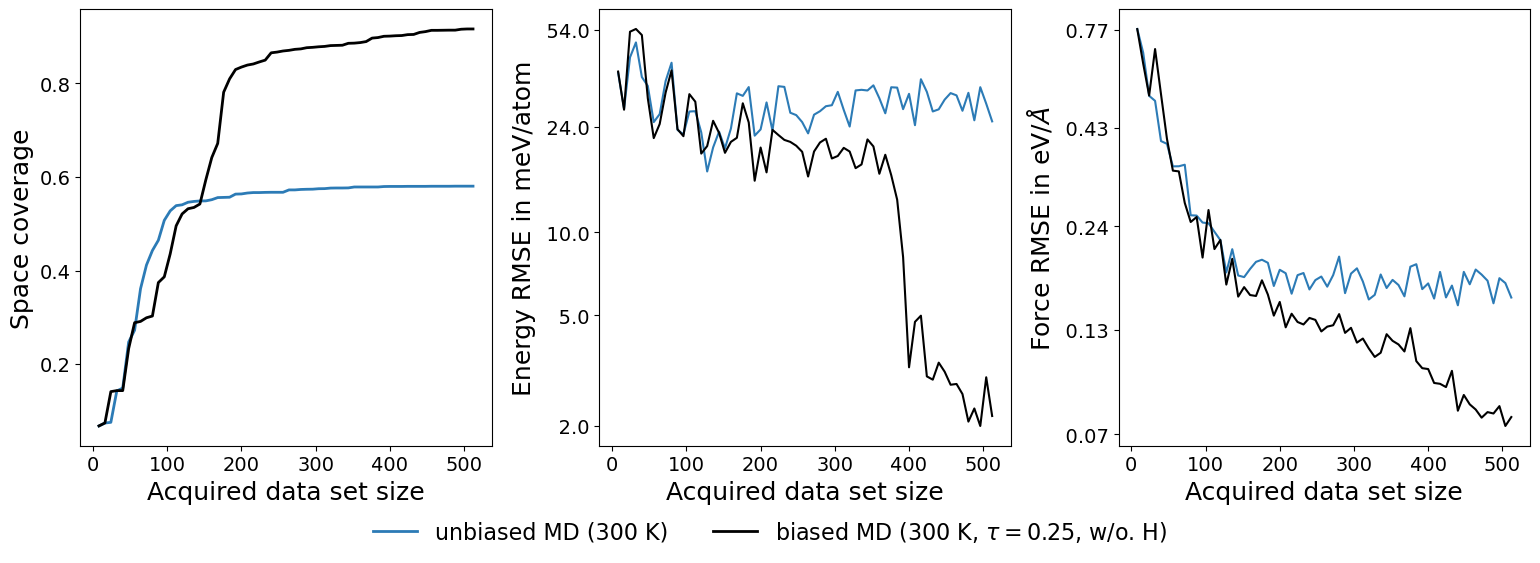

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15.5, 6))

# Subplot 1

for key in results:
    n_data = np.array(results[key]['learning_curves']['n_train']) + np.array(results[key]['learning_curves']['n_valid'])
    axs[0].plot(n_data, results[key]['coverage'], '-', linewidth=2.0, color=results[key]['color'], label=results[key]['key'], alpha=results[key]['alpha'])
    
# axs[0].set_ylim(0, 1)
axs[0].set_xlabel('Acquired data set size', fontsize=18)
axs[0].set_ylabel('Space coverage', fontsize=18)

axs[0].set_title('')

# Subplot 2

for key in results:
    n_data = np.array(results[key]['learning_curves']['n_train']) + np.array(results[key]['learning_curves']['n_valid'])
    energy_rmse = np.array(results[key]['learning_curves']['avg_energy_per_atom_rmse'])
    axs[1].plot(n_data, np.log(energy_rmse), '-', color=results[key]['color'], label=results[key]['key'], alpha=results[key]['alpha'])

axs[1].set_xlabel('Acquired data set size', fontsize=18)
axs[1].set_ylabel('Energy RMSE in meV/atom', fontsize=18, labelpad=-10)
axs[1].set_title('')

logspace = np.round(np.logspace(np.log10(min(energy_rmse)), np.log10(max(energy_rmse)), 5, endpoint=True), 3)
ylocs = [np.log(ival) for ival in logspace]
ylabels = (f'{ival * 1000:8.1f}' for ival in logspace)
axs[1].set_yticks(ylocs)
axs[1].set_yticklabels(ylabels)

# Subplot 3

for key in results:
    n_data = np.array(results[key]['learning_curves']['n_train']) + np.array(results[key]['learning_curves']['n_valid'])
    force_rmse = np.array(results[key]['learning_curves']['avg_forces_rmse'])
    axs[2].plot(n_data, np.log(force_rmse), '-', color=results[key]['color'], label=results[key]['key'], alpha=results[key]['alpha'])

axs[2].set_xlabel('Acquired data set size', fontsize=18)
axs[2].set_ylabel('Force RMSE in eV/$\AA$', fontsize=18, labelpad=-10)
axs[2].set_title('')

logspace = np.round(np.logspace(np.log10(min(force_rmse)), np.log10(max(force_rmse)), 5, endpoint=True), 2)
ylocs = [np.log(ival) for ival in logspace]
ylabels = (f'{ival:8.2f}' for ival in logspace)
axs[2].set_yticks(ylocs)
axs[2].set_yticklabels(ylabels)

axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=14)

fig.legend(*axs[0].get_legend_handles_labels(), fontsize=16, framealpha=0, bbox_to_anchor=(0.5, 0.05), loc='lower center', ncol=4)

plt.tight_layout(rect=[0, 0.125, 1.0, 1.0])
fig.patch.set_alpha(0)

plt.show()

Finally, we look at the Ramachandran plots.

In [13]:
def read_exp_traj(exp_path: Union[Path, str]):
    # read trajectory of the whole experiment
    exp_path = Path(exp_path)
    traj = []

    step_folders = os.listdir(exp_path)
    sorted_step_folders = sorted(step_folders, key=last_chars)
    
    for step_folder in sorted_step_folders:
        if step_folder.startswith('step'):
            try:
                sampler_folders = os.listdir(exp_path / step_folder / 'sampling')
                sorted_sampler_folders = sorted(sampler_folders, key=last_chars)
                for sampler_folder in sorted_sampler_folders:
                    if sampler_folder.startswith('sampler'):
                        traj.extend(read(exp_path / step_folder / 'sampling' / sampler_folder / 'sampler.traj', ':'))
            except Exception as e:
                print(e)

    return traj

In [14]:
def plot_ramachandran(ax,
                      experiment: Path[str, Path],
                      phi_atoms: List[int],
                      psi_atoms: List[int],
                      use_colorbar: bool = False,
                      set_y_label: bool = False,
                      set_x_label: bool = False):
    # prepare a Ramachandran plot

    assert len(phi_atoms) == len(psi_atoms) == 4
    

    if os.path.exists(custom_paths.results_path /  experiment / 'dihedrals.npz'):
        data = np.load(custom_paths.results_path /  experiment / 'dihedrals.npz')
        phis, psis = data['phis'], data['psis']
    else:
        traj = read_exp_traj(custom_paths.results_path /  experiment)
        phis = get_dihedral(traj, *phi_atoms)
        psis = get_dihedral(traj, *psi_atoms)
        np.savez(custom_paths.results_path / experiment / 'dihedrals.npz', phis=phis, psis=psis)
    
    hb = ax.hexbin(phis, psis, gridsize=50, bins='log', cmap='inferno')

    ax.axvline(0, c='k', ls='--')
    ax.axhline(0, c='k', ls='--')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    locs = [-180.0, 0.0, 180.0]
    labels = (r'$-\pi$', '0', r'$\pi$')
    ax.set_yticks(locs)
    ax.set_yticklabels(labels)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    
    if set_x_label:
        ax.set_xlabel(r'$\varphi$', fontsize=22)
    
    if set_y_label:
        ax.set_ylabel(r'$\psi$', fontsize=22)
    
    if use_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.15)
        cb = plt.colorbar(hb, cax=cax)
        cb.ax.tick_params(labelsize=16)
        cb.ax.set_ylabel('Counts', fontsize=18)

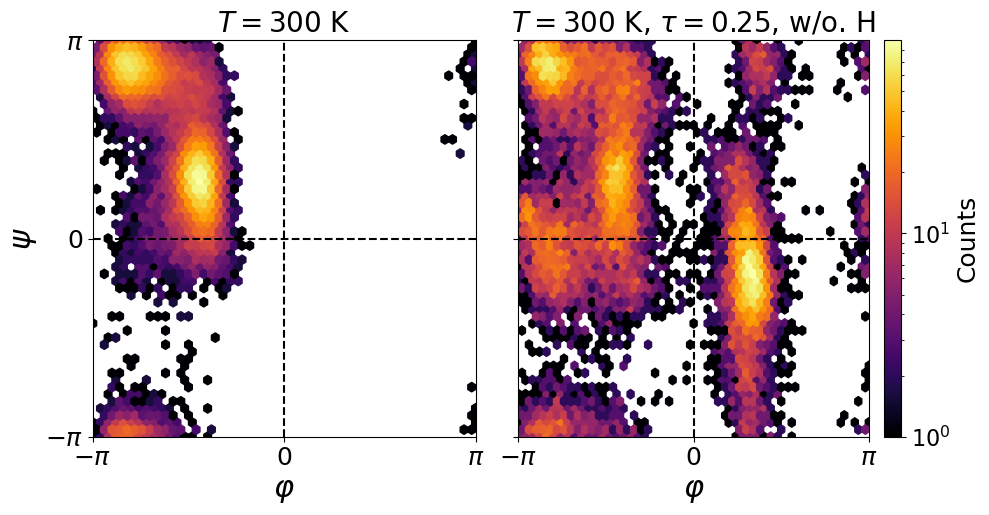

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5.25), sharey=True)

plot_ramachandran(axs[0], 'ala2-300K-ffs/random_8_0.02-nvt_1.5_20000_200_8-posterior-max_det_8_512-0', phi_atoms=[4, 6, 8, 14], psi_atoms=[6, 8, 14, 16], set_y_label=True, set_x_label=True)
axs[0].set_title(r'$T=300$ K', fontsize=20)

plot_ramachandran(axs[1], 'ala2-300K-ffs/random_8_0.02-nvt_1.5_20000_200_8-linear_unc_0.25_0.0-posterior-max_det_8_512-0', phi_atoms=[4, 6, 8, 14], psi_atoms=[6, 8, 14, 16], set_x_label=True, use_colorbar=True)
axs[1].set_title(r'$T=300$ K, $\tau=0.25$, w/o. H', fontsize=20)

axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout(rect=[0, 0.0, 1.0, 1.0])
fig.patch.set_alpha(0)

plt.show()